## Source: https://github.com/RobRomijnders/vi_normal

In [5]:
import numpy as np
from approx_posterior import make_approx_posterior
from exact_posterior import make_exact_posterior
from util import Plot_contour_pdf, q_mean_field_distro, ELBO, normal_inv_chi2_distro

## Helpers

In [6]:
def make_exact_posterior(data, plot):
    # First calculate exact results
    # Our prior parameters
    # mu ~ Normal(mu0, sigma_squared/k0)
    # sigma_squared ~ inverse_chi_squared(nu0, sigma_squared0)
    mu_0 = 0.
    k_0 = 1.
    nu_0 = 1.
    sigma2_0 = 1.

    # Find posterior parameters
    # Equations 4.225-4.229 in Murphy
    x_mean = np.mean(data)
    N = len(data)
    k_N = k_0 + N
    nu_N = nu_0 + N
    mu_N = (k_0 * mu_0 + N * x_mean) / k_N
    sigma2_N = 1/nu_N * (nu_0 * sigma2_0 + np.sum(np.square(data - x_mean)) + N*k_0/k_N*(mu_0-x_mean)**2)

    nix2 = normal_inv_chi2_distro(mu_N, k_N, nu_N, sigma2_N)

    plot(nix2, num_points_plot=50, basename='exact_posterior')


In [21]:
def make_approx_posterior(data, plot):
    # Prior parameters
    # mu ~ Normal(mu0, 1/(lambda*k0))
    # lambda ~ gamma(a0, b0)
    mu_0 = 0.0
    k_0 = 1.0
    a_0 = 1
    b_0 = 1

    # Calculate the posterior parameters
    N = len(data)
    mu_N = (k_0*mu_0 + N*np.mean(data))/(k_0 + N)
    a_N = a_0 + (N+1)/2
    k_N = 1  # Some initial guess

    num_steps = 10
    ELBO_prev = -1E9
    for step in range(num_steps):
        E_mu2 = 1/k_N + np.power(mu_N, 2)
        b_N = b_0 + k_0*(E_mu2 + mu_0**2 - 2*mu_N*mu_0) + 0.5*np.sum(np.power(data, 2) + E_mu2 - 2*mu_N*data)
        k_N = (k_0 + N) * (a_N / b_N)

        # Chech that the ELBO increases monotonically
        ELBO_current = ELBO(k_N, a_N, b_N)
        assert ELBO_current >= ELBO_prev
        ELBO_prev = ELBO_current
        print('ELBO at step %3i/%3i is %8.5f, ELBO -log is  %8.5f' % (step, num_steps, ELBO_current, np.log(-ELBO_current)))

        # Plot
        q_mean_field = q_mean_field_distro(mu_N, k_N, a_N, b_N)
        plot(q_mean_field, num_points_plot=50, basename='approx_posterior', stepname=step)

[ 0.61654388  1.29956105  1.42747425 -0.27745316  1.4227485   0.28027411
  1.19708789  1.4434733   1.89750385  0.2602109   0.08802036  0.42238232
  2.26608352  0.42463614 -0.38894609 -0.13384166  1.61448465  2.14254728
  1.82105964 -1.42232109  3.07549576 -0.25848545  2.28772534  1.10659785
  3.32090191  0.15836725  0.80276367  0.82233779  0.83858108  2.2143436
 -0.13939997  1.26209857  2.44426957  2.20038932 -2.02859178  0.13804876
 -1.1536362   2.78994704 -3.05332018  1.23889402  1.02630313 -0.47694847
  1.34444544  0.92243516  1.86306566 -1.19075839  1.83552292 -0.5845453
  0.70673876 -1.51475576  0.99615474 -1.20861756  0.02279202 -0.61853198
  0.51995385  1.07282317 -1.10906137  1.95312532  0.86156745  1.99907903]
ELBO at step   0/ 10 is -64.37272, ELBO -log is   4.16469
ELBO at step   1/ 10 is -50.65343, ELBO -log is   3.92501
ELBO at step   2/ 10 is -50.37375, ELBO -log is   3.91947
ELBO at step   3/ 10 is -50.36922, ELBO -log is   3.91938
ELBO at step   4/ 10 is -50.36915, ELBO

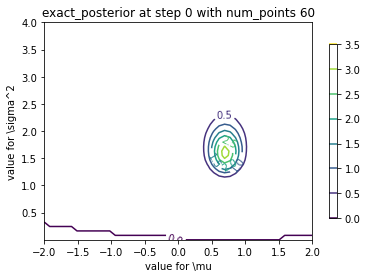

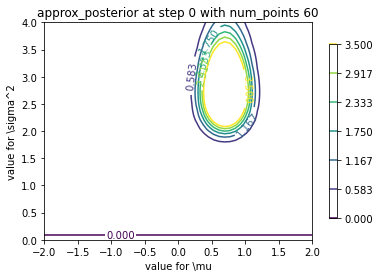

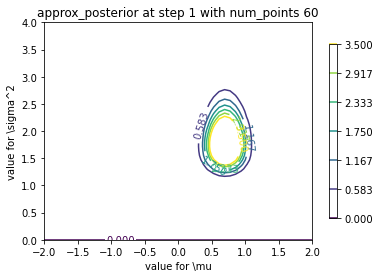

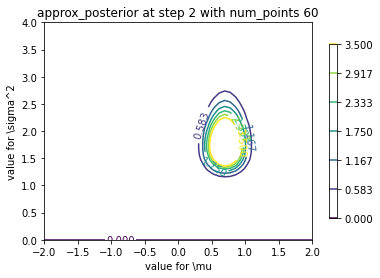

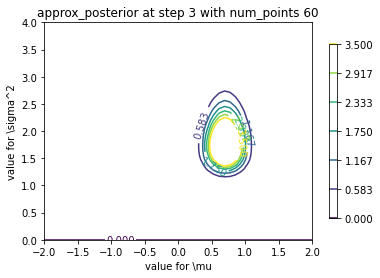

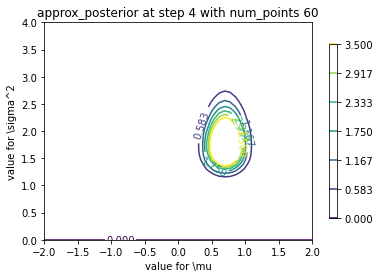

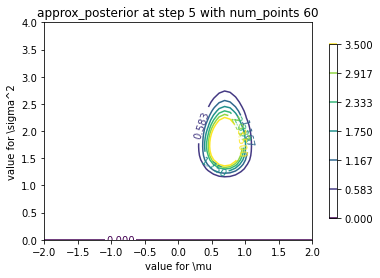

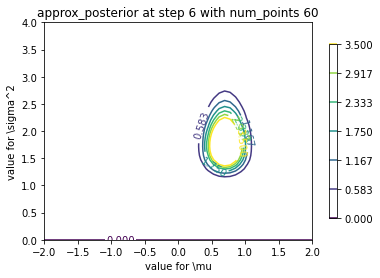

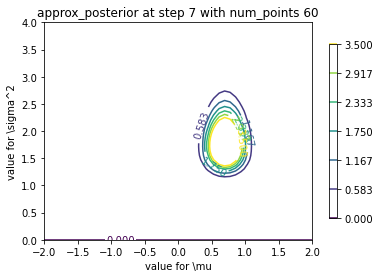

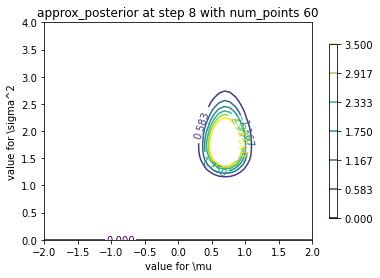

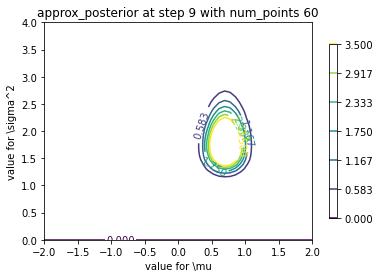

In [22]:
def main():
    # Generate data
    mu_gen = 0.7
    sigma_gen = 1.3
    N_gen = 60
    data = mu_gen + np.random.normal(size=(N_gen,))*sigma_gen
    print(data)

    # Make a plotting object so that we can use equal contour lines
    plot_contour = Plot_contour_pdf(N_gen)

    make_exact_posterior(data, plot_contour)
    make_approx_posterior(data, plot_contour)

    print('Sample mean %5.3f \nSample variance %5.3f' % (np.mean(data), np.var(data)))


if __name__ == "__main__":
    main()